In [ ]:
!python -m pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
yaml_content = """
train: /content/drive/MyDrive/Brain/Train
val: /content/drive/MyDrive/Brain/Val

nc: 4  # Number of classes

names: ["Giloma", "Meningioma", "No TUMOR","Pitutary"]  # List of class names
"""

# Define the path where you want to save the data.yaml file
yaml_path = "/content/drive/MyDrive/Brain/data.yaml"

# Write the content to the file
with open(yaml_path, "w") as file:
    file.write(yaml_content)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv(nn.Module):
    def __init__(self, c1, c2, k=3, s=1):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, kernel_size=k, stride=s, padding=k//2, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class C2f(nn.Module):
    def __init__(self, c1, c2, n=1):
        super().__init__()
        self.blocks = nn.Sequential(*[Conv(c1 if i == 0 else c2, c2) for i in range(n)])

    def forward(self, x):
        return self.blocks(x)

class SPPF(nn.Module):
    def __init__(self, c1, c2, k=5):
        super().__init__()
        self.conv1 = Conv(c1, c2, 1, 1)
        self.pool = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
        self.conv2 = Conv(c2 * 4, c2, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.pool(x)
        y2 = self.pool(y1)
        y3 = self.pool(y2)
        return self.conv2(torch.cat([x, y1, y2, y3], dim=1))

class YOLOv8Showcase(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Conv(3, 32, 3, 2),                # 1
            Conv(32, 64, 3, 2),               # 2
            C2f(64, 64, 1),                   # 3
            Conv(64, 128, 3, 2),              # 4
            C2f(128, 128, 2),                 # 5
            Conv(128, 256, 3, 2),             # 6
            C2f(256, 256, 2),                 # 7
            Conv(256, 512, 3, 2),             # 8
            C2f(512, 512, 1),                 # 9
            SPPF(512, 512),                   # 10
        )
        # Neck
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')  # 11
        self.c2f1 = C2f(768, 256, 1)                             # 12
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')  # 13
        self.c2f2 = C2f(384, 128, 1)                             # 14
        self.down1 = Conv(128, 128, 3, 2)                        # 15
        self.c2f3 = C2f(384, 256, 1)                             # 16
        self.down2 = Conv(256, 256, 3, 2)                        # 17
        self.c2f4 = C2f(768, 512, 1)                             # 18
        self.head = nn.Conv2d(512, 4, 1)                         # 19 - Detect layer

    def forward(self, x):
        outputs = []
        for i in range(10):
            x = self.layers[i](x)
            outputs.append(x)
        x = self.up1(x)
        x = torch.cat([x, outputs[6]], dim=1)
        x = self.c2f1(x)
        x = self.up2(x)
        x = torch.cat([x, outputs[4]], dim=1)
        x = self.c2f2(x)
        x = self.down1(x)
        x = torch.cat([x, self.c2f1.output], dim=1)
        x = self.c2f3(x)
        x = self.down2(x)
        x = torch.cat([x, outputs[9]], dim=1)
        x = self.c2f4(x)
        return self.head(x)

# Showcase run
model = YOLOv8Showcase()
x = torch.randn(1, 3, 640, 640)
out = model(x)
print("Output shape:", out.shape)


KeyboardInterrupt: 

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data="/content/drive/MyDrive/Brain/data.yaml" epochs=1 imgsz=800 plots=True

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 21.5M/21.5M [00:00<00:00, 42.2MB/s]
Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Brain/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hs

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data="/content/drive/MyDrive/Brain/data.yaml" epochs=30 imgsz=800 plots=True

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Brain/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

In [ ]:
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolov8s.pt')

# Train the model
model.train(data='/content/drive/MyDrive/Brain/data.yaml', epochs=40, imgsz=800, plots=True)


KeyboardInterrupt: 

In [ ]:
import shutil

# Path to the trained model
trained_model_path = '/content/drive/runs/detect/train2/weights/best.pt'

# Path to save the model in your Google Drive
drive_model_path = '/content/drive/runs/brain/folder/best_model.pt'

# Copy the model to Google Drive
shutil.copy(trained_model_path, drive_model_path)

print(f"Model saved to: {drive_model_path}")

In [ ]:
import shutil

# Create a zip file from the 'runs' folder
shutil.make_archive('/content/runs', 'zip', '/content/runs')


'/content/runs.zip'

In [ ]:
from google.colab import files
files.download('/content/runs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving gg (16).jpg to gg (16).jpg


In [ ]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('best.pt')


image 1/1 /content/gg (16).jpg: 800x800 1 Giloma, 8.1ms
Speed: 19.0ms preprocess, 8.1ms inference, 333.3ms postprocess per image at shape (1, 3, 800, 800)


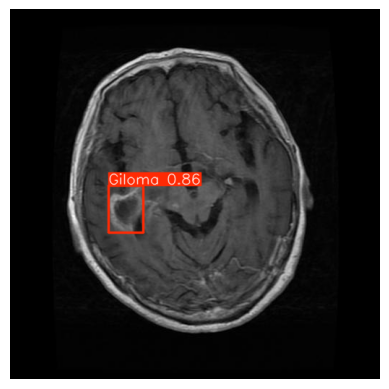

In [ ]:
image_path = list(uploaded.keys())[0]

results = model(image_path)

img_with_boxes = results[0].plot()
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()